# Linear Regression

a) (5 points) Convert the training images into grayscale, flatten each image into a vector of length
4096 (64x64) and load them into a numpy array. You will obtain a matrix of size 10,000x4096.
You might need to use an additional library for this, e.g. `Pillow`.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime  # for measuring time

In [14]:
DATA = "data/linearRegression_data"
SHAPE_TRAIN = "3dshapes_train"
SHAPE_TEST = "3dshapes_test"
ORIENTATIONS_TRAIN = "orientations_train.npy"
ORIENTATIONS_TEST = "orientations_test.npy"

In [15]:
def load_npy_file(data_dir: str, file_name: str) -> np.array:
    return np.load(f"{data_dir}/{file_name}")

def load_data(data_dir, shape_dir, orientations_dir, size):
    image_list = [] # store images in the memory
    for i in range(size):
        filename = f"{data_dir}/{shape_dir}/{i}.jpg"
        im=Image.open(filename)
        image_list.append(np.array(im.convert('L')))   
    
    orientations = load_npy_file(data_dir, orientations_dir)
    return np.array(image_list), np.array(orientations)

def flatten(images): # im shape: (batch, width, height)
    return np.array([im.flatten() for im in images])

In [38]:
# loading the data may take some time (it took ~3 minutes on my machine)
X_train, y_train = load_data(DATA, SHAPE_TRAIN, ORIENTATIONS_TRAIN, size = 10000)
X_test, y_test = load_data(DATA, SHAPE_TEST, ORIENTATIONS_TEST, size = 1000)

X_train_flattened = flatten(X_train)
X_test_flattened = flatten(X_test)

X_train_flattened.shape, y_train.shape, X_test_flattened.shape, y_test.shape

((10000, 4096), (10000,), (1000, 4096), (1000,))

b) (10 points) Please pose predicting the orientation of images as a linear regression problem.
Implement and train a linear regression model from scratch. Compute the solution $w^*$. You can
also find a test set consisting of 1000 images under the `3dshapes-test` folder. Use the solution
vector you obtained to make predictions on the test data. Report the Root Mean Square Error
(MSE) between your predictions and target values in the `orientations-test.npy` file.


Analytical solution for linear regression:
$$
\begin{aligned}
w = (X^TX)^{-1}&X^Ty \newline
\hat{y} = Xw& \newline
\hat{y} = X(X^TX)^{-1}&X^Ty
\end{aligned}
$$
where $X$ is a matrix of size $n \times d$ where $n$ is the number of samples and $d$ is the number of features. $y$ is a vector of size $n$ containing the target values. $w$ is a vector of size $d$ containing the weights. $(X^TX)^{-1}X^T$ is the pseudo-inverse of $X$.

In [17]:
class LinearRegression:
    def __init__(self, X: np.array, y: np.array):
        self.X = X
        self.X = np.hstack((np.ones((self.X.shape[0], 1)), self.X)) # add x_0 = 1 to each x
        self.y = y
        self.w = None
    
    def solve(self):
        start = datetime.now()
        self.w = np.linalg.pinv(self.X) @ self.y
        end = datetime.now()
        delta = end - start
        print(f"Time for solving analytically: {int(delta.total_seconds())} seconds")
    
    def predict(self, X: np.array) -> np.array:
        X = np.hstack((np.ones((X.shape[0], 1)), X)) # add x_0 = 1 to each x
        return X @ self.w

    @staticmethod
    def MSE(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
        return ((y_true - y_pred)**2).mean()

In [18]:
# this may take some time
lr = LinearRegression(X_train_flattened, y_train)
lr.solve()

Time for solving analytically: 49 seconds


In [19]:
y_pred = lr.predict(X_test_flattened)
mse = LinearRegression.MSE(y_test, y_pred)
print(f"MSE: {mse}")

MSE: 0.007739958244019011


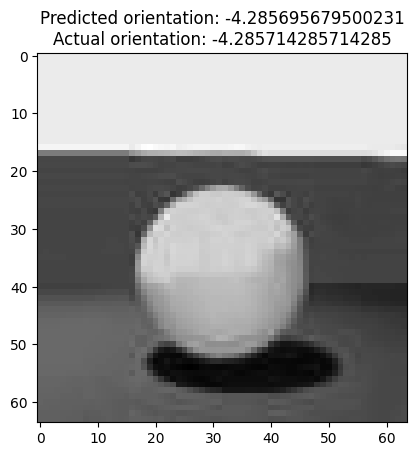

In [20]:
def compare_pred(X_test, y_test, y_pred):
    testid = np.random.randint(0, X_test.shape[0])
    plt.imshow(X_test[testid], cmap='gray')
    plt.title(f"Predicted orientation: {y_pred[testid]}\nActual orientation: {y_test[testid]}")
    plt.show()

compare_pred(X_test=X_test, y_test=y_test, y_pred=y_pred)

c) Using the entire image as the feature vector requires a large data matrix that
complicates the computations. To alleviate this issue, review the feature extraction literature
or design your own features to come up with a more compact representation per image. Apply
the technique of your choice to obtain the feature vectors for each image and explain the
reasons behind your choice. Train the linear regression model with your new features and
report the MSE on the test features. Did you improve your previous results, or are the current
results worse? Discuss the possible reasons. Do not forget to cite your references.

### Pooling
Since images do not contain so many details, _max pooling_, _min pooling_ or _average pooling_ can be used to reduce the number of features. This way, we can decrease the amount of time it takes for training our model. Pooling is a concept commonly used in Computer Vision problems in order to reduce the spatial dimensions of the data and achieve better performance. In our case, inevitably, the resulting MSE with the new features will be higher than the previous one but we will be gaining a tremendous improvement in the training time. Naturally, there is a trade-off between training time and model accuracy. For spatial pooling, it is explicitly stated that, "Spatial pooling fuses information of input across spatial locations. Thereby the number of parameters is decreased and thus the computational cost." [\[1\]](https://arxiv.org/pdf/1908.05040.pdf). There are various papers in the literature that compares different pooling strategies with each other such as [\[2\]](https://arxiv.org/ftp/arxiv/papers/2009/2009.07485.pdf). We decided to go with _max pooling_.

1. Christlein, Vincent & Spranger, Lukas & Seuret, Mathias & Nicolaou, Anguelos & Král, Pavel & Maier, Andreas. (2019). Deep Generalized Max Pooling. 1090-1096. 10.1109/ICDAR.2019.00177. 
2. Gholamalinezhad H., Khosravi H. (2020). Pooling Methods in Deep Neural Networks, a Review. arXiv preprint arXiv:2009.07485. 

In [21]:
# apply max-pool to images
def max_pool(X, pool_size):
    batch, width, height = X.shape
    X = np.array([ np.max(X[i, :, :].reshape(width // pool_size, pool_size, height //pool_size, pool_size), axis=(1, 3)) for i in range(batch)])
    return X.reshape(-1, width //pool_size * height // pool_size)

In [22]:
# make sure that the data is loaded to memory (run the previous cells)
X_train_maxp = max_pool(X_train, pool_size = 4)
X_test_maxp = max_pool(X_test, pool_size = 4)

X_train_maxp.shape, X_train_maxp.shape

((10000, 256), (10000, 256))

In [23]:
# this may take some time (it took ~5 minutes on my machine)
lr = LinearRegression(X_train_maxp, y_train)
lr.solve()

y_pred = lr.predict(X_test_maxp)
mse = LinearRegression.MSE(y_test, y_pred)
print(f"MSE: {mse}")

Time for solving analytically: 0 seconds
MSE: 1.463361605676602


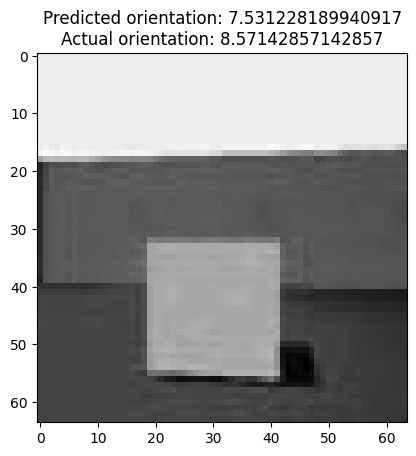

In [24]:
compare_pred(X_test=X_test, y_test=y_test, y_pred=y_pred)

As you can see, execution time decreased from approximately ~1 minutes to ~5 seconds (these results may change). But unfortunately, MSE increased from 0.007 to 1.46 - which was expected since we lost information by applying spatial pooling to the images. Depending on your application and to what extent you care about the precise accuracy of the orientation, this model can be preferred over the former model due to the lower execution time.

### HOG Feature Descriptor

We can also use another method called The Histogram of Oriented Gradients (HOG), which was originally proposed by Navneet Dalal and Bill Triggs in 2005. HOG is a feature descriptor used in computer vision and image processing for the purpose of object detection. It counts occurrences of gradient orientation in localized portions of an image. The HOG descriptor is a feature vector that is computed from the gradient image. The gradient image is computed by convolving the image with a pair of filters that are sensitive to horizontal and vertical gradients. The gradient image is then divided into small connected regions called cells. For each cell, a histogram of gradient or edge orientations is compiled. The cell-based histograms are then normalized, aggregated into a feature vector, and used as a compact image representation. [\[3\]](https://www.learnopencv.com/histogram-of-oriented-gradients/)


3. Dalal, N and Triggs, B, Histograms of Oriented Gradients for Human Detection, IEEE Computer Society Conference on Computer Vision and Pattern Recognition 2005 San Diego, CA, USA, https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf, :DOI:`10.1109/CVPR.2005.177`

In [25]:
from skimage.feature import hog

In [26]:
def extract_HOG_features(images, orientations=9, pixels_per_cell=(8, 8)):
    hog_images = np.array([hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,
						cells_per_block=(3, 3)) for img in images])
    return hog_images

X_train_HOG = extract_HOG_features(X_train)
X_test_HOG = extract_HOG_features(X_test)

X_train_HOG.shape, X_test_HOG.shape

((10000, 2916), (1000, 2916))

In [27]:
lr = LinearRegression(X_train_HOG, y_train)
lr.solve()

y_pred = lr.predict(X_test_HOG)
mse = LinearRegression.MSE(y_test, y_pred)
print(f"MSE: {mse}")

Time for solving analytically: 20 seconds
MSE: 1.0441801772188941


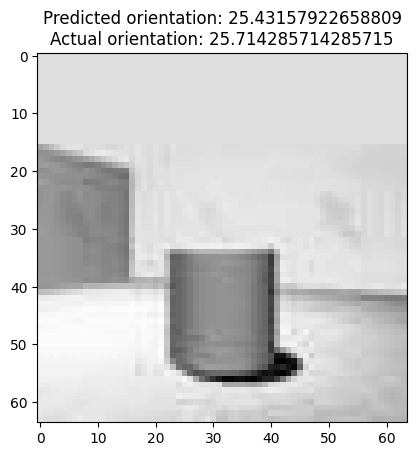

In [28]:
compare_pred(X_test=X_test, y_test=y_test, y_pred=y_pred)

## Principal Component Analysis

In [40]:
from sklearn.decomposition import PCA

def apply_PCA(X_train, X_test):
    X_train_flattened = flatten(X_train)
    X_test_flattened = flatten(X_test)

    # Scale = (x - mean) / std
    with np.errstate(divide='ignore', invalid='ignore'):
        X_train_scaled = (X_train_flattened - X_train_flattened.mean(axis=0)) / X_train_flattened.std(axis=0)
        X_test_scaled = (X_test_flattened - X_test_flattened.mean(axis=0)) / X_test_flattened.std(axis=0)

    # deal with divide by 0
    X_train_scaled = np.nan_to_num(X_train_scaled)
    X_test_scaled = np.nan_to_num(X_test_scaled)

    pca = PCA(n_components=0.99) # %99 variance
    X_train = pca.fit_transform(X_train_scaled)
    X_test = pca.transform(X_test_scaled)
    return X_train, X_test

X_train_PCA, X_test_PCA = apply_PCA(X_train, X_test)
X_train_PCA.shape, X_test_PCA.shape

((10000, 202), (1000, 202))

In [11]:
lr = LinearRegression(X_train_PCA, y_train)
lr.solve()

y_pred = lr.predict(X_test_PCA)
mse = LinearRegression.MSE(y_test, y_pred)
print(f"MSE: {mse}")

Time for solving analytically: 0 seconds
MSE: 0.6842918985811821


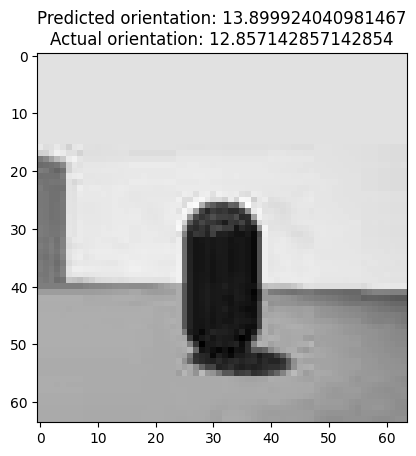

In [41]:
compare_pred(X_test=X_test, y_test=y_test, y_pred=y_pred)

In [42]:
## experiment

def feature(X_train, X_test, cls = "default"):
    if cls == "default":
        return flatten(X_train), flatten(X_test)
    elif cls == "max_pool":
        return max_pool(X_train, pool_size = 4), max_pool(X_test, pool_size = 4)
    elif cls == "HOG":
        return extract_HOG_features(X_train), extract_HOG_features(X_test)
    elif cls == 'PCA':
        return apply_PCA(X_train, X_test)
    else:
        raise ValueError("Unknown feature extraction method")
    
def run(X_train, X_test, y_train, y_test, n = 5):
    ### run each experiment n times. Measure the average time and average MSE
    mse_list = {"default": [], "HOG": [], "PCA": [], "max_pool": []}
    time_list = {"default": [], "HOG": [], "PCA": [], "max_pool": []}
    for _ in range(n):
        for cls in mse_list.keys():
            X_train_, X_test_ = feature(X_train, X_test, cls)
            lr = LinearRegression(X_train_, y_train)
            start = datetime.now()
            lr.solve()
            end = datetime.now()
            delta = end - start
            time_list[cls].append(int(delta.total_seconds() * 1000))
            y_pred = lr.predict(X_test_)
            mse = LinearRegression.MSE(y_test, y_pred)
            mse_list[cls].append(mse)
    return mse_list, time_list

In [43]:
mse_list, time_list = run(X_train, X_test, y_train, y_test, n = 5)

Time for solving analytically: 54 seconds
Time for solving analytically: 19 seconds
Time for solving analytically: 0 seconds
Time for solving analytically: 0 seconds
Time for solving analytically: 41 seconds
Time for solving analytically: 20 seconds
Time for solving analytically: 0 seconds
Time for solving analytically: 0 seconds
Time for solving analytically: 46 seconds
Time for solving analytically: 21 seconds
Time for solving analytically: 0 seconds
Time for solving analytically: 0 seconds
Time for solving analytically: 45 seconds
Time for solving analytically: 19 seconds
Time for solving analytically: 0 seconds
Time for solving analytically: 0 seconds
Time for solving analytically: 46 seconds
Time for solving analytically: 18 seconds
Time for solving analytically: 0 seconds
Time for solving analytically: 0 seconds


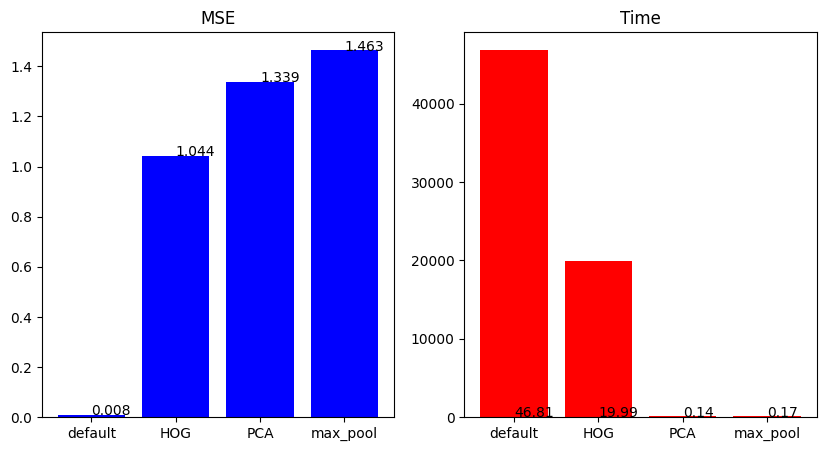

In [46]:
def plot_values(y, ms = False):
    for i in range(len(y)):
        r = round(y[i], 3)
        r = round(r / 1000, 2) if ms else r
        plt.text(i, r, r)

# plot the results
def plot_results(mse_list, time_list):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    mse_mean = [np.mean(mse_list[key]) for key in mse_list.keys()]
    time_mean = [np.mean(time_list[key]) for key in time_list.keys()]
    plt.title("MSE")
    plt.bar(mse_list.keys(),mse_mean, color="blue")
    plot_values(mse_mean)
    plt.subplot(1, 2, 2)
    plt.title("Time")
    plt.bar(time_list.keys(),time_mean, color="red")
    plot_values(time_mean, ms = True)
    plt.show()

plot_results(mse_list, time_list)